# Investigating the Length Scale of Bailer-Jones+18 distances

Recent work by [Bailer-Jones et al. 2018](http://adsabs.harvard.edu/abs/2018arXiv180410121B) (hereafter BJ+18) appropriately inferred distances to stars in the *Gaia* DR2 sample using Bayesian analysis involving applying a distance prior and using the mode of the posterior distribution this generates as their distance estimate. The prior uses a length scale $L > 0$ to describe the exponentially decreasing space density of targets. The justification for this prior can be found in [Bailer-Jones 2015](http://adsabs.harvard.edu/abs/2015PASP..127..994B) (hereafter BJ15).

This in opposition to the more 'traditional' case of dividing 1 by the parallax to obtain distance, which does not hold true for targets with large parallax errors or negative parallaxes, which are nonetheless valid astrometric solutions.

The work in BJ+18 uses *Galaxia* models subdivided into cells across the sky to fit for a value of $L$, before fititng a spherical harmonic model to obtain the length scale $L(l,b)$ as a function of galactic latitude and longitude.

This blog aims to check the validity of these length scales by using [TRILEGAL](http://stev.oapd.inaf.it/cgi-bin/trilegal) simluations to investigate how the length scale varies depending on *stellar type*, and how this affects the inferred distances to these targets.

I'm not going to draw any lofty conclusions about which length scale is appropriate--- I just aim to initiate a discussion on how we go about using parallaxes and any catalogued distances!

You can find me on: [Twitter](www.twitter.com/asteronomer) | [Github](www.github.com/ojhall94) | ojhall94 -at- gmail -dot- com

If you want to skip how I fit for different values of $L$ and go straigh to the plots, click [**here**](#plots). If you're just interested in my conclusions, click [**here**](#conclusions) to skip to the bottom.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

import pandas as pd
from astropy.table import Table
from tqdm import tqdm

import omnitool    #You can find this repository on my Github!
from omnitool.literature_values import *

import sys

rerun = True

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Lets have a quick look at how the BJ+18 prior length scale L changes as a function of RA and Dec in Kepler

The below catalogue was compiled by [Megan Bedell](https://github.com/megbedell) can be found [here](https://gaia-kepler.fun/])!

In [2]:
data = Table.read('../data/KepxDR2/kepler_dr2_1arcsec.fits', format='fits')
kdf = data.to_pandas()
kdf.rename(columns={'kepid':'KICID'},inplace=True)
kdf.head(2)
print(len(kdf))

195830


Lets also have a look at how these values change (if at all) for an exclusively RC sample, as idenitfied in [Yu+18](http://adsabs.harvard.edu/abs/2018arXiv180204455Y). Given the nature BJ+18's calculation of L, we don't expect any differences.

In [3]:
sfile = '../data/KepxDR2/MRCxyu18_wdupes_BC.csv'
yu18 = pd.read_csv(sfile,index_col=0)
print(len(yu18))

7725


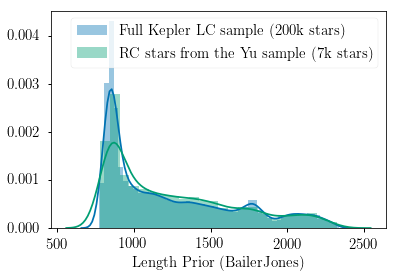

In [4]:
sns.distplot(kdf.r_length_prior,label='Full Kepler LC sample (200k stars)')
sns.distplot(yu18.r_length_prior,label='RC stars from the Yu sample (7k stars)')
plt.legend(fontsize=15)
plt.xlabel('Length Prior (BailerJones)',fontsize=15)
plt.show()

Thus we can confirm that in the catalogue published by BJ+18, there is no evident separate treatement of the distance prior for Red Clump stars. This is expected, as BJ+18 calculate $L(l,b)$ as a function of galactic position, but its good to check anyway before proceeding to the next step.

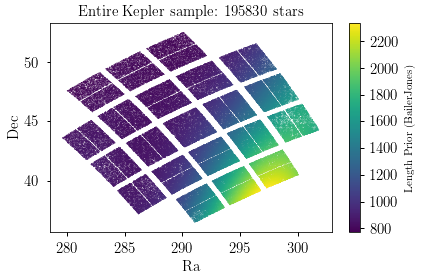

In [5]:
fig, ax = plt.subplots()
c = ax.scatter(kdf.ra, kdf.dec,s=0.1,c=kdf.r_length_prior,vmin=kdf.r_length_prior.min(), vmax=kdf.r_length_prior.max())
ax.set_title('Entire Kepler sample: '+str(len(kdf))+' stars',fontsize=15)
ax.set_xlabel('Ra',fontsize=15)
ax.set_ylabel('Dec',fontsize=15)

fig.colorbar(c,label='Length Prior (BailerJones)')
fig.tight_layout()
plt.show()

In this blog, we won't worry about how L changes with galactic position, just how it differs for stellar types. We'll thus be using a isotropic $L$. In a pefect world, we'd have a full skymap fit for L using *Galaxia* for every stellar type.

## Now lets investigate which values of L are appropriate for different stellar types using TRILEGAL

In [6]:
tdf = pd.read_csv('../data/TRILEGAL_sim/k1.6b_K15b30_0910_new.all.out.txt',sep='\s+')
tdf['Ak'] = omnitool.literature_values.Av_coeffs['Ks'].values[0]*tdf.Av
tdf['MK'] = tdf.Ks - tdf['m-M0'] - tdf.Ak
tdf['dist'] = 10.0**(tdf['m-M0'] / 5.0 + 1.0)

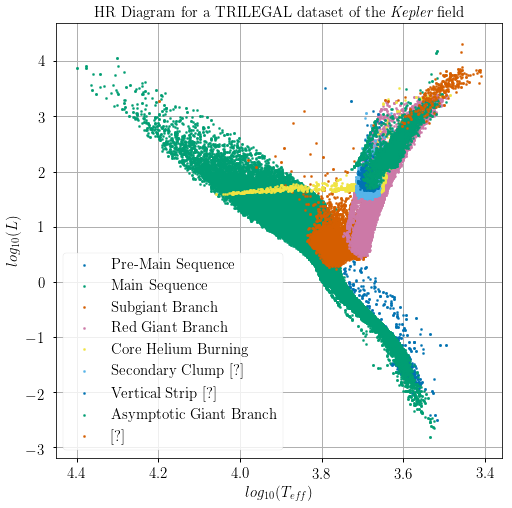

In [7]:
m_ks = tdf['Ks'].values
mu = tdf['m-M0'].values
Av = tdf['Av'].values
M = tdf['Mact'].values
labels =tdf['stage'].values
Zish = tdf['[M/H]'].values
logT = tdf['logTe'].values
logL = tdf['logL'].values

fig, ax = plt.subplots(figsize=(8,8))
label = ['Pre-Main Sequence', 'Main Sequence', 'Subgiant Branch', 'Red Giant Branch', 'Core Helium Burning',\
            'Secondary Clump [?]', 'Vertical Strip [?]', 'Asymptotic Giant Branch','[?]']
for i in range(int(np.nanmax(labels))+1):
    ax.scatter(logT[labels==i],logL[labels==i],s=5,label=label[i])
ax.legend(loc='best',fancybox=True,fontsize=15)
ax.invert_xaxis()
ax.set_xlabel(r"$log_{10}(T_{eff})$",fontsize=15)
ax.set_ylabel(r'$log_{10}(L)$',fontsize=15)
ax.set_title(r"HR Diagram for a TRILEGAL dataset of the $\textit{Kepler}$ field",fontsize=15)
ax.grid()
ax.set_axisbelow(True)
plt.show(fig)


Just to clarify, there are a couple of stellar classifications in there that I am uncertain of, and given the label '\[?\]'. However due to to their position in the HR Diagram I have taken the liberty of classifying them as giant stars. Not also that despite the colour similarities, the stars at the high end of the giant branch do not belong to the subgiant population.

We'll plot below the distribution of TRILEGAL distances for different stellar groups, namely 'Giants' (everything RGB and later) and 'Dwarfs' (main sequence stars). Subgiants and pre-MS stars have been excluded. Post-giant stars are not included in the simulation.

In [8]:
giantmask = tdf.stage >= 3.
dwarfmask = tdf.stage == 1.

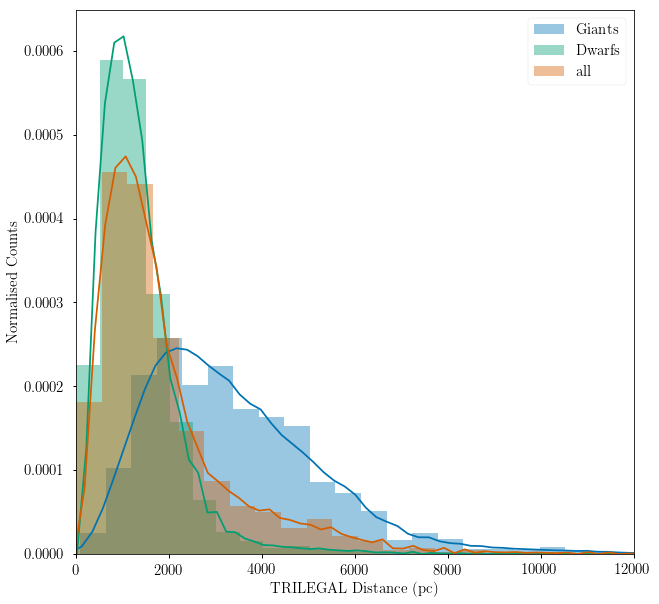

In [9]:
fig = plt.figure(figsize=(10,10))
sns.distplot(tdf.dist[giantmask],label='Giants')
sns.distplot(tdf.dist[dwarfmask],label='Dwarfs')
sns.distplot(tdf.dist, label='all')
plt.ylabel('Normalised Counts',fontsize=15)
plt.xlabel('TRILEGAL Distance (pc)',fontsize=15)
plt.xlim(0, 12000)
plt.legend(fontsize=15)
plt.show()

I have applied a limit on the plot at $12 kpc$ for clarity. Clearly, the distribution of distances is different for different stellar types, as we'd expect from their differing luminosity functions.

#### We'll use a simple PyStan model to fit the BJ15 distance prior to the data and find a length scale L appropriate for these stellar groups.

This **exponentially decreasing space density** distance prior, as found in Bailer-Jones15, described further in Bailer-Jones+18, and applied in Pystan in Hawkins+17, goes as

### $P(r | L) = \frac{1}{2L^3}r^2e^{-r/L}$,
for $r > 0$ and 0 everywhere else, where L is a length scale.

I have chosen to apply a uninformative uniform prior on $L$ ranging from $0.1pc$ to $4kpc$.

In [10]:
import pystan
lmodel = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower=0> N;
    real r[N];
}
parameters {
    real<lower=.1, upper=4000.> L;
}
model {
    for (n in 1:N){
        r[n] ~ bailerjones(L);
    }
}
'''
if rerun:
    sm = pystan.StanModel(model_code=lmodel, model_name='lmodel')
else:
    pass

INFO:pystan:COMPILING THE C++ CODE FOR MODEL lmodel_fd8651f5e23d60506623f70ecc9faf8a NOW.


##### Giant stars

In [11]:
if rerun:
    d = tdf.dist[giantmask].values
    dat = {'N':len(d),
          'r' : d}
    fit = sm.sampling(data=dat, iter=1000, chains=2)

/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


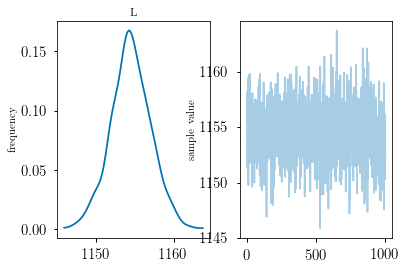

Inference for Stan model: lmodel_fd8651f5e23d60506623f70ecc9faf8a.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L    1154.4    0.15   2.55 1149.2 1152.7 1154.3 1156.1 1159.6  296.0   1.01
lp__ -6.5e5    0.04   0.79 -6.5e5 -6.5e5 -6.5e5 -6.5e5 -6.5e5  328.0    1.0

Samples were drawn using NUTS at Wed May 23 14:50:43 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [12]:
if rerun:
    L_giant = np.median(fit['L'])
    fit.plot()
    plt.show()
    print(fit)
else:
    L_giant = 1154.42

##### Dwarf stars

In [13]:
if rerun:
    d = tdf.dist[dwarfmask].values
    dat = {'N':len(d),
          'r' : d}
    fit = sm.sampling(data=dat, iter=1000, chains=2)

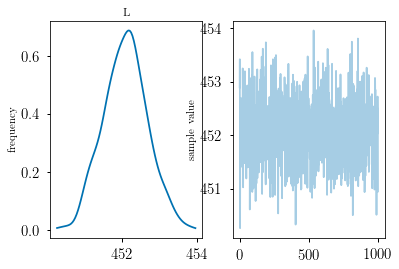

Inference for Stan model: lmodel_fd8651f5e23d60506623f70ecc9faf8a.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L    452.09    0.03   0.58  451.0 451.69 452.11 452.48 453.27  396.0    1.0
lp__ -1.6e6    0.04   0.71 -1.6e6 -1.6e6 -1.6e6 -1.6e6 -1.6e6  368.0    1.0

Samples were drawn using NUTS at Wed May 23 14:54:15 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [14]:
if rerun:
    L_dwarf = np.median(fit['L'])
    fit.plot()
    plt.show()
    print(fit)
else:
    L_dwarf = 452.13

##### Full sample

In [15]:
if rerun:
    d = tdf.dist.values
    dat = {'N':len(d),
          'r' : d}
    fit = sm.sampling(data=dat, iter=1000, chains=2)

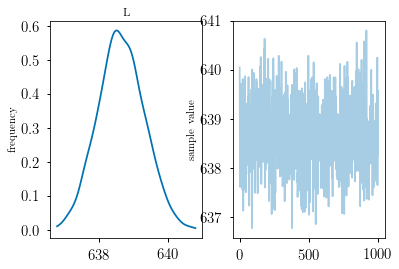

Inference for Stan model: lmodel_fd8651f5e23d60506623f70ecc9faf8a.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L    638.64    0.03   0.67 637.36 638.19 638.62 639.08 639.97  378.0   1.01
lp__ -2.6e6    0.03   0.67 -2.6e6 -2.6e6 -2.6e6 -2.6e6 -2.6e6  480.0    1.0

Samples were drawn using NUTS at Wed May 23 14:59:47 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [16]:
if rerun:
    L_all = np.median(fit['L'])
    fit.plot()
    plt.show()
    print(fit)
else:
    L_all = 638.7

#### Now lets look at the results!

In [17]:
def bjl(r, L):
    return (1/(2*L**3)) * (r*r) * np.exp(-r/L);

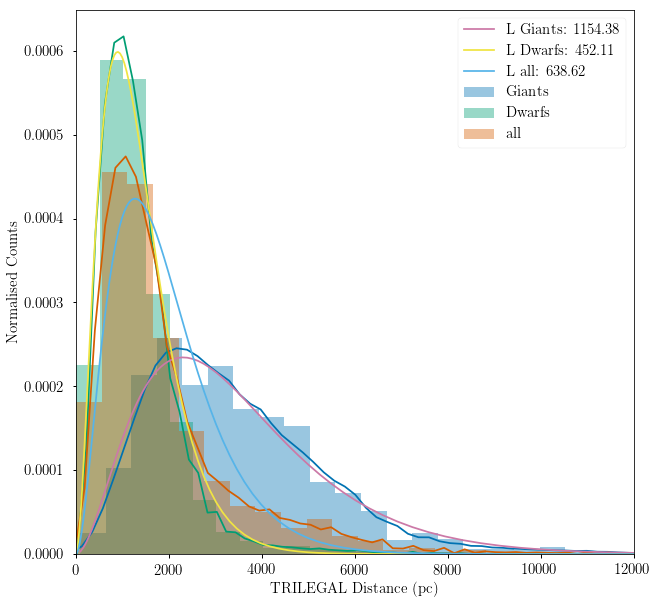

In [18]:
fig = plt.figure(figsize=(10,10))
sns.distplot(tdf.dist[giantmask],label='Giants')
sns.distplot(tdf.dist[dwarfmask],label='Dwarfs')
sns.distplot(tdf.dist, label='all')
plt.plot(np.sort(tdf.dist[giantmask]), bjl(np.sort(tdf.dist[giantmask]),L_giant),label='L Giants: '+str(np.round(L_giant,2)))
plt.plot(np.sort(tdf.dist[dwarfmask]), bjl(np.sort(tdf.dist[dwarfmask]),L_dwarf),label='L Dwarfs: '+str(np.round(L_dwarf,2)))
plt.plot(np.sort(tdf.dist), bjl(np.sort(tdf.dist), L_all),label='L all: '+str(np.round(L_all,2)))

plt.ylabel('Normalised Counts',fontsize=15)
plt.xlabel('TRILEGAL Distance (pc)',fontsize=15)
plt.legend(fontsize=15)
plt.xlim(0., 12000)
plt.show()

In the Figure it appears that the distribution matches well to dwarf stars and to giant stars separately, but struggles to find a clean fit for the full sample.

The value of L also differs by close to a factor of 3 between the two stellar groups, and by a factor of 2 from the value found from a fit to the full set of data.

This is important, as the work by BJ+18 describes the calculation of L as being done for patches of sky, but not for different stellar groups.

## Lets investigate how this changes the posterior distributions that distance estimates are drawn from

If we assume parallax values to be distributed normally as $N(\varpi | 1/r, \sigma_{\varpi})$, then given the prior on distance and Bayes equation, we can find the ($\textbf{unnormalised!}$) posterior over the distance to be (as seen in BJ+18):

### $P^*(r | \varpi, \sigma_\varpi, L) = r^2 \exp\bigg[-\frac{r}{L} - \frac{1}{2\sigma^2_\varpi} \bigg(\varpi - \frac{1}{r}\bigg)^2\bigg]$ 
for $r > 0$, and 0 everywhere else. Right now we only care about the mode of the posterior and not its power, so we'll be omitting the normalisation for the rest of this blog.

Note that I have made some changes from the version given in BJ+18; L is no longer a function of galactic position, and I have omitted the global parallax zeropoint $\varpi_{zp}$ as I am working with simulated data.

I should probably note that TRILEGAL provides distance modulus and not parallax, so my synthetic parallaxes will be generated as $1/r$, and uncertainties will be inserted at the parallax level. The use of $1/r$ doesn't matter for what we're doing, as we want to see the $\textbf{quantitative}$ difference a change in $L$ and $\sigma_\varpi$ make to the esitmated distance, and we will assume the uncertainties on the simulated distances to be practically zero.

In [19]:
def postprob_un(r, L, oo, oo_err):
    return r**2 * np.exp(-(r/L) - (1/(2*oo_err**2))*(oo - (1./r))**2)

In [20]:
r = np.linspace(0., 10000, 100000)
tdf['oo'] = 1/tdf.dist
tdf['oo_err'] = .1*tdf.oo

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  


Parallax: 1.096 mas
Error: 0.548 mas == 50.0%


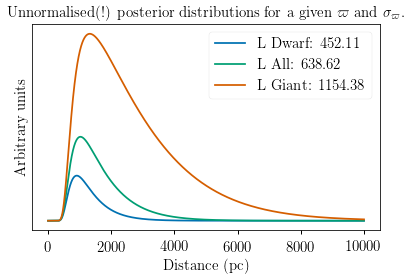

In [21]:
def plot_postprob_un(r, L_dwarf, L_all, L_giant, oo, oo_err):
    fig = plt.figure()
    plt.plot(r,postprob_un(r, L_dwarf, oo, oo_err),label='L Dwarf: '+str(np.round(L_dwarf,2))) 
    plt.plot(r,postprob_un(r, L_all, oo, oo_err),label='L All: '+str(np.round(L_all,2)))
    plt.plot(r,postprob_un(r, L_giant, oo, oo_err),label='L Giant: '+str(np.round(L_giant,2)))
    plt.plot(label='Test')
    plt.title(r'Unnormalised(!) posterior distributions for a given $\varpi$ and $\sigma_\varpi$.',fontsize=15)
    plt.xlabel('Distance (pc)',fontsize=15)
    plt.ylabel('Arbitrary units',fontsize=15)
    plt.yticks([])
    fig.tight_layout()
    plt.legend(fontsize=15)
    print('Parallax: '+str(np.round(1000*oo,3))+' mas')
    print('Error: '+str(np.round(1000*oo_err,3))+' mas == '+str(oo_err*100/oo)+'%')
plot_postprob_un(r, L_dwarf, L_all, L_giant, tdf.oo[0], tdf.oo_err[0]*5)

As expected, the shape of the posterior is very different to a Gaussian distribution for uncertain targets, and thus the $1/r$ transformation does not hold for these objects.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  


Parallax: 1.096 mas
Error: 0.11 mas == 10.0%


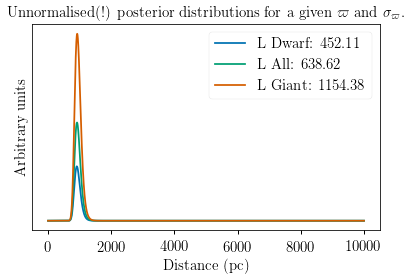

In [22]:
plot_postprob_un(r, L_dwarf, L_all, L_giant, tdf.oo[0], tdf.oo_err[0])

As you can see, if we decrease the uncertainty, the result becomes a lot more constrained, the modes of the posteriors for different L are closer, and the posteriors tend towards a normal distribution in the limit that $\sigma_\varpi \rightarrow 0.$

As stated in BJ+18:
>While the posterior\[s\] \[above\] \[are\] the complete description of the distance to the source, we often want to use a single point estimate along with some measure of the uncertainty. \[...\] As the point estimator $r_{est}$, we prefer here the mode, $r_{mode}$. This is found analytically by solving a cubic equation.

This cubic equation can be found by setting $P^*(r | \varpi, \sigma_\varpi, L)/dr = 0$, which gives

### $\frac{r^3}{L} - 2r^2 + \frac{\varpi}{\sigma_\varpi^2}r - \frac{1}{\sigma_\varpi^2} = 0$

We evaluate this using $\texttt{numpy.roots}$ in this blog, and employ the following evaluation criteria given in BJ15:

>Inspection of the roots leads to the following strategy for assigning the distance estimator \[...\] from the modes:
- If there is one real root, it is a maximum: select this as the mode.
- If there are three real roots, there are two maxima:
 -  If $\varpi \geq 0$, select the smallest root as the mode.
 - If $\varpi < 0$, select the mode with r > 0 (there is only one).
 
Note that the latter is not relevant to this test, as we do not have any negative parallax in the sample. I've nonetheless included the criterion in the code in case anybody wants to apply it elsewhere.

We will be calculating $r_{mode}$ for each star in the TRILEGAL sample using each of the values of L, and for a range of parallax uncertainties.

In [23]:
def get_roots(L, oo, oo_err):
    p = np.array([1./L, -2, oo/oo_err**2., -1./oo_err**2.])
    roots = np.roots(p)
    if len(roots) == 1:
        return float(roots[0])
    if len(roots) == 3:
        if oo >= 0.:
            return float(np.min(roots[np.isreal(roots)]))
        if oo < 0.:
            return float(roots[np.isreal(roots)][roots > 0])
    else:
        print('You shouldnt be here, printing roots below for diagnostic:')
        print(roots)
        
def get_modes(L, oo, oo_err):
    return np.array([get_roots(L, o, err) for o, err in zip(oo, oo_err)])

In [24]:
idf = pd.DataFrame()

Ls = {'all':L_all,
    'dwarfs':L_dwarf,
    'giants':L_giant}
types = ['all','dwarfs','giants']

errange = np.arange(.05,.55,.05)

for ltype in types:
    for err in tqdm(errange):
        label='r_'+ltype+'_'+str(np.round(err,2))
        idf[label] = get_modes(Ls[ltype], tdf.oo, tdf.oo*err)
idf['oo'] = tdf.oo
idf['oo_err'] = tdf.oo_err
idf['r_true'] = tdf.dist

idf.sort_values('r_true', inplace=True)
idf.head(5)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
100%|██████████| 10/10 [03:24<00:00, 20.47s/it]


,r_all_0.05,r_all_0.1,r_all_0.15,r_all_0.2,r_all_0.25,r_all_0.3,r_all_0.35,r_all_0.4,r_all_0.45,r_all_0.5,...,r_giants_0.2,r_giants_0.25,r_giants_0.3,r_giants_0.35,r_giants_0.4,r_giants_0.45,r_giants_0.5,oo,oo_err,r_true
195791,11.538996,11.718551,12.044778,12.571974,13.422320,14.939713,19.350772,1240.642549,1248.503636,1254.065610,...,12.577836,13.435288,14.973855,19.654230,2272.495959,2280.204198,2285.685801,0.087096,0.008710,11.481536
138419,16.678583,16.936987,17.406197,18.163608,19.382581,21.546009,27.592924,1223.848249,1235.444253,1243.604364,...,18.175828,19.409546,21.616491,28.158367,2256.081481,2267.343586,2275.330410,0.060256,0.006026,16.595869
288988,17.464566,17.734967,18.225918,19.018286,20.293091,22.553751,28.837261,1221.251147,1233.432294,1241.996757,...,19.031681,20.322635,22.630893,29.447359,2253.556580,2265.369065,2273.742595,0.057544,0.005754,17.378008
288989,17.464566,17.734967,18.225918,19.018286,20.293091,22.553751,28.837261,1221.251147,1233.432294,1241.996757,...,19.031681,20.322635,22.630893,29.447359,2253.556580,2265.369065,2273.742595,0.057544,0.005754,17.378008
100114,17.464566,17.734967,18.225918,19.018286,20.293091,22.553751,28.837261,1221.251147,1233.432294,1241.996757,...,19.031681,20.322635,22.630893,29.447359,2253.556580,2265.369065,2273.742595,0.057544,0.005754,17.378008


<a id="plots"></a>
## Now lets make some illustrative plots!

In [25]:
bisector = np.linspace(idf['r_true'].min(), idf['r_true'].max(), 10)

### First, lets see how the estimated mode distance compares to the 'true' TRILEGAL distance for each length scale, for various fractional uncertainties

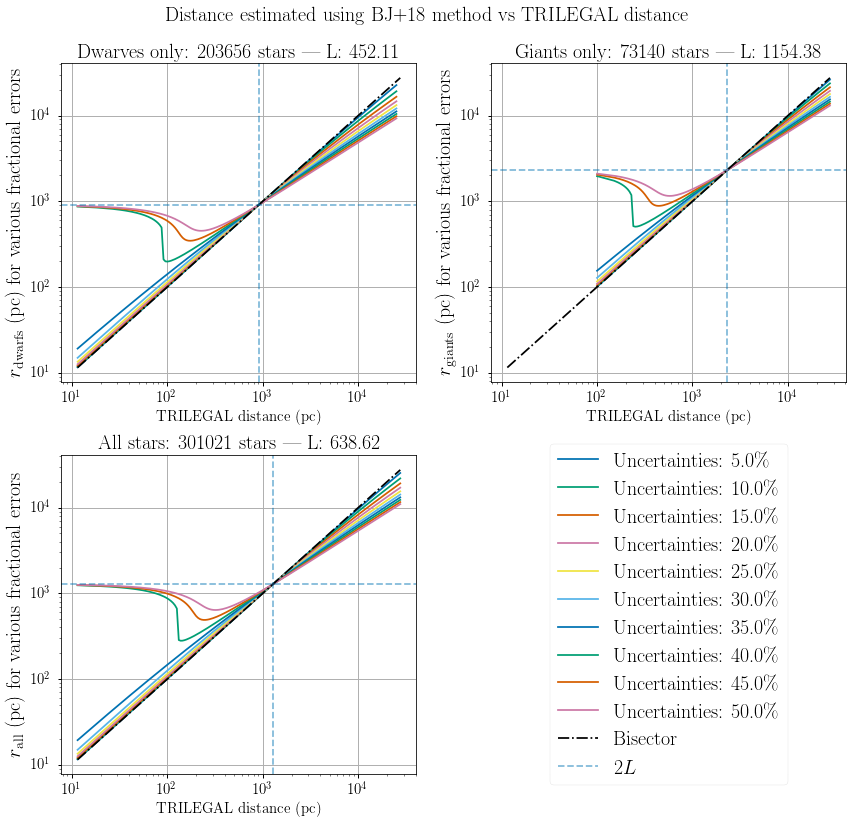

In [33]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
for err in errange:
    ax[0,0].loglog(idf['r_true'][dwarfmask],idf['r_dwarfs_'+str(np.round(err,2))][dwarfmask])
    ax[0,1].loglog(idf['r_true'][giantmask],idf['r_giants_'+str(np.round(err,2))][giantmask])
    ax[1,0].loglog(idf['r_true'],idf['r_all_'+str(np.round(err,2))])
    ax[1,1].plot(idf['r_true'][0:1],idf['r_true'][0:1],label='Uncertainties: '+str(np.round(err,2)*100)+'\%')

ax[0,0].plot(bisector,bisector,linestyle='-.',c='k')
ax[0,0].axvline(2*L_dwarf,linestyle='--',alpha=.5)
ax[0,0].axhline(2*L_dwarf,linestyle='--',alpha=.5)
ax[0,0].set_xlabel('TRILEGAL distance (pc)',fontsize=15)
ax[0,0].set_ylabel(r'$r_{\rm dwarfs}$ (pc) for various fractional errors',fontsize=20)
ax[0,0].set_title('Dwarves only: '+str(len(idf['r_true'][dwarfmask]))+' stars | L: '+str(np.round(L_dwarf,2)), fontsize=20)
ax[0,0].grid()

ax[0,1].plot(bisector,bisector,linestyle='-.',c='k')
ax[0,1].axvline(2*L_giant,linestyle='--',alpha=.5)
ax[0,1].axhline(2*L_giant,linestyle='--',alpha=.5)
ax[0,1].set_xlabel('TRILEGAL distance (pc)',fontsize=15)
ax[0,1].set_ylabel(r'$r_{\rm giants}$ (pc) for various fractional errors',fontsize=20)
ax[0,1].set_title('Giants only: '+str(len(idf['r_true'][giantmask]))+' stars | L: '+str(np.round(L_giant,2)), fontsize=20)
ax[0,1].grid()

ax[1,0].plot(bisector,bisector,linestyle='-.',c='k')
ax[1,0].axvline(2*L_all,linestyle='--',alpha=.5)
ax[1,0].axhline(2*L_all,linestyle='--',alpha=.5)
ax[1,0].set_xlabel('TRILEGAL distance (pc)',fontsize=15)
ax[1,0].set_ylabel(r'$r_{\rm all}$ (pc) for various fractional errors',fontsize=20)
ax[1,0].set_title('All stars: '+str(len(idf['r_true']))+' stars | L: '+str(np.round(L_all,2)), fontsize=20)
ax[1,0].grid()

ax[1,1].plot(bisector,bisector,linestyle='-.',c='k',label='Bisector')
ax[1,1].axvline(2*L_dwarf,linestyle='--',alpha=.5, label=r'$2L$')
ax[1,1].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_xlim(-5,-4)
ax[1,1].set_ylim(-5,-4)
ax[1,1].legend(fancybox=True,loc='center',fontsize=20)
ax[1,1].spines['bottom'].set_edgecolor('white')
ax[1,1].spines['top'].set_edgecolor('white')
ax[1,1].spines['left'].set_edgecolor('white')
ax[1,1].spines['right'].set_edgecolor('white')
    
fig.suptitle('Distance estimated using BJ+18 method vs TRILEGAL distance',fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

There are a number of important observations we can make about these plots, given the prior we apply on the distance:

- The distances match the bisector relatively well for all values of $L$ for low uncertainties. This is expected-- at low uncertainties the prior will play a relatively small role in the posterior distribution and thus the choice of $L$ will have less impact.


- There is a turning point for the residuals across the bisector which lies at a distance of $2L$ for each $L$. This value is the location of the mode of the distance prior. This again is as we expect; at $r < 2L$, targets with larger uncertainties will be biased towards a higher estimate of distance. For targets at $r > 2L$, they will be biased towards a lower estimate of distance, which is reflected in the shape of the residuals.


- At low distances with large fractional errors the stars start behaving particularly strangely. This again, is expected. Small $r$ means high $\varpi$, meaning quantatively large $\sigma_\varpi$ at high fractional uncertainties. When fractional uncertainties are this high, **the prior dominates the distance estimate**. Since these are high parallax stars, the *true* distance is low, wheras the prior forces the *estimate* towards a value of $r = 2L$. This is especially visible for the closest stars, which clearly have distance estimates that lie at the $2L$ position.

### Now, lets look at how the choice of L changes the distance residuals

We'll compare $r_{dwarfs}$ and $r_{giants}$ to the 'true' TRILEGAL distance $r_{true} respectively, and will plot the fractional difference in radius, ie:

### $\Delta_{true, dwarfs} = \frac{r_{dwarfs} - r_{true}}{r_{true}}$

For the sake of clarity, I will not be including any of the data for fractional uncertainties $>35 \%$, as we now know that the distance estimates for these stars inflate wildly at small distances.

In [34]:
idf['r_true'] = tdf['dist']
for err in tqdm(errange):
    idf['d_true_dwarfs_'+str(np.round(err,2))] = (idf['r_dwarfs_'+str(np.round(err,2))] - idf['r_true'])/idf['r_true']
    idf['d_true_giants_'+str(np.round(err,2))] = (idf['r_giants_'+str(np.round(err,2))] - idf['r_true'])/idf['r_true']
    idf['d_true_all_'+str(np.round(err,2))] = (idf['r_all_'+str(np.round(err,2))] - idf['r_true'])/idf['r_true']

100%|██████████| 10/10 [00:00<00:00, 119.01it/s]


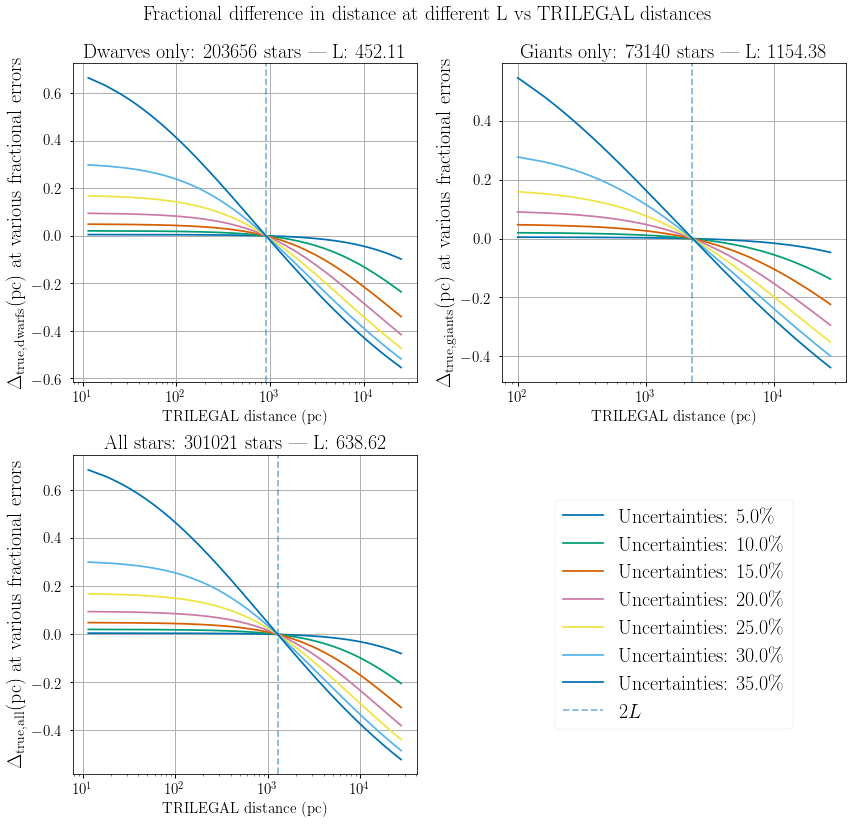

In [35]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
for err in errange[0:-3]:
    ax[0,0].semilogx(idf['r_true'][dwarfmask],idf['d_true_dwarfs_'+str(np.round(err,2))][dwarfmask])
    ax[0,1].semilogx(idf['r_true'][giantmask],idf['d_true_giants_'+str(np.round(err,2))][giantmask])
    ax[1,0].semilogx(idf['r_true'],idf['d_true_all_'+str(np.round(err,2))])
    ax[1,1].plot(idf['r_true'][0:1],idf['r_true'][0:1],label='Uncertainties: '+str(np.round(err,2)*100)+'\%')

ax[0,0].axvline(2*L_dwarf,linestyle='--',alpha=.5)
ax[0,0].set_xlabel('TRILEGAL distance (pc)',fontsize=15)
ax[0,0].set_ylabel(r'$\Delta_{\rm true, dwarfs}$(pc) at various fractional errors',fontsize=20)
ax[0,0].set_title('Dwarves only: '+str(len(idf['r_true'][dwarfmask]))+' stars | L: '+str(np.round(L_dwarf,2)), fontsize=20)
ax[0,0].grid()

ax[0,1].axvline(2*L_giant,linestyle='--',alpha=.5)    
ax[0,1].set_xlabel('TRILEGAL distance (pc)',fontsize=15)
ax[0,1].set_ylabel(r'$\Delta_{\rm true, giants}$(pc) at various fractional errors',fontsize=20)
ax[0,1].set_title('Giants only: '+str(len(idf['r_true'][giantmask]))+' stars | L: '+str(np.round(L_giant,2)), fontsize=20)
ax[0,1].grid()

ax[1,0].axvline(2*L_all,linestyle='--',alpha=.5)    
ax[1,0].set_xlabel('TRILEGAL distance (pc)',fontsize=15)
ax[1,0].set_ylabel(r'$\Delta_{\rm true, all}$(pc) at various fractional errors',fontsize=20)
ax[1,0].set_title('All stars: '+str(len(idf['r_true']))+' stars | L: '+str(np.round(L_all,2)), fontsize=20)
ax[1,0].grid()

ax[1,1].axvline(2*L_dwarf,linestyle='--',alpha=.5, label=r'$2L$')
ax[1,1].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_xlim(-5,-4)
ax[1,1].set_ylim(-5,-4)
ax[1,1].legend(fancybox=True,loc='center',fontsize=20)
ax[1,1].spines['bottom'].set_edgecolor('white')
ax[1,1].spines['top'].set_edgecolor('white')
ax[1,1].spines['left'].set_edgecolor('white')
ax[1,1].spines['right'].set_edgecolor('white')

fig.suptitle('Fractional difference in distance at different L vs TRILEGAL distances',fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

There are a number of important observations we can make about these plots at a glance:

- At large distances the estimated distance becomes prior dominated, even at low uncertainties-- in fact you can see that the lower the uncertainty, the later the prior domination kicks in. This is expected behaviour, and is a result of us not setting a fixed limit on the maximum distance in our prior (see  BJ15).


- At low distance (high parallax) the estimated distances match relatively well with $<10\%$ residuals for fractional uncertainties at $20\%$ and below.


- Only at very low uncertainties do the residuals remain close to zero after the $2L$ limit, after which the posteriors become quickly prior dominated.

For a better idea of how this relates to parallax, I have plotted the same data below with parallax on the x-axis.

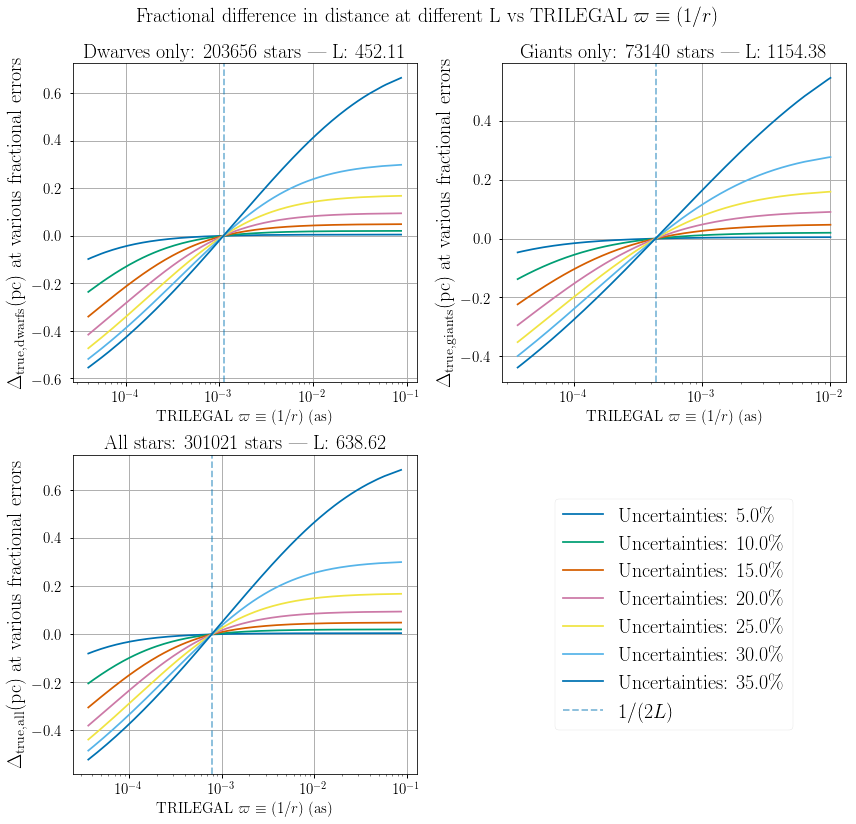

In [46]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
for err in errange[0:-3]:
    ax[0,0].semilogx(idf['oo'][dwarfmask],idf['d_true_dwarfs_'+str(np.round(err,2))][dwarfmask])
    ax[0,1].semilogx(idf['oo'][giantmask],idf['d_true_giants_'+str(np.round(err,2))][giantmask])
    ax[1,0].semilogx(idf['oo'],idf['d_true_all_'+str(np.round(err,2))])
    ax[1,1].plot(idf['oo'][0:1],idf['oo'][0:1],label='Uncertainties: '+str(np.round(err,2)*100)+'\%')

ax[0,0].axvline((1/(2*L_dwarf)),linestyle='--',alpha=.5)
ax[0,0].set_xlabel(r'TRILEGAL $\varpi \equiv (1/r)$ (as)',fontsize=15)
ax[0,0].set_ylabel(r'$\Delta_{\rm true, dwarfs}$(pc) at various fractional errors',fontsize=20)
ax[0,0].set_title('Dwarves only: '+str(len(idf['r_true'][dwarfmask]))+' stars | L: '+str(np.round(L_dwarf,2)), fontsize=20)
ax[0,0].grid()

ax[0,1].axvline((1/(2*L_giant)),linestyle='--',alpha=.5)    
ax[0,1].set_xlabel(r'TRILEGAL $\varpi \equiv (1/r)$ (as)',fontsize=15)
ax[0,1].set_ylabel(r'$\Delta_{\rm true, giants}$(pc) at various fractional errors',fontsize=20)
ax[0,1].set_title('Giants only: '+str(len(idf['r_true'][giantmask]))+' stars | L: '+str(np.round(L_giant,2)), fontsize=20)
ax[0,1].grid()

ax[1,0].axvline((1/(2*L_all)),linestyle='--',alpha=.5)    
ax[1,0].set_xlabel(r'TRILEGAL $\varpi \equiv (1/r)$ (as)',fontsize=15)
ax[1,0].set_ylabel(r'$\Delta_{\rm true, all}$(pc) at various fractional errors',fontsize=20)
ax[1,0].set_title('All stars: '+str(len(idf['r_true']))+' stars | L: '+str(np.round(L_all,2)), fontsize=20)
ax[1,0].grid()

ax[1,1].axvline(2*L_dwarf,linestyle='--',alpha=.5, label=r'$1/(2L)$')
ax[1,1].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_xlim(-5,-4)
ax[1,1].set_ylim(-5,-4)
ax[1,1].legend(fancybox=True,loc='center',fontsize=20)
ax[1,1].spines['bottom'].set_edgecolor('white')
ax[1,1].spines['top'].set_edgecolor('white')
ax[1,1].spines['left'].set_edgecolor('white')
ax[1,1].spines['right'].set_edgecolor('white')

fig.suptitle(r'Fractional difference in distance at different L vs TRILEGAL $\varpi \equiv (1/r)$',fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Finally, lets look at how the choice of L affects the estimated mode distance between different estimates
To make a more realstic comparison to the way distances are found in BJ+18, let's compare the estimated mode distances obtained through our length scales for dwarves and giants, to the distances obtained using the length scale fit for the full sample--- so we'll forget about the 'true' TRILEGAL distances temporarily, and just make an internal comparison on the choice of L.

We'll compare $r_{all}$ to $r_{dwarfs}$ and $r_{giants}$ respectively, and will plot the fractional difference in radius, ie:

### $\Delta_{dwarfs} = \frac{r_{dwarfs} - r_{all}}{r_{all}}$

In [37]:
idf['r_true'] = tdf['dist']
for err in tqdm(errange):
    idf['d_dwarfs_'+str(np.round(err,2))] = (idf['r_dwarfs_'+str(np.round(err,2))] - idf['r_all_'+str(np.round(err,2))])/idf['r_all_'+str(np.round(err,2))]
    idf['d_giants_'+str(np.round(err,2))] = (idf['r_giants_'+str(np.round(err,2))] - idf['r_all_'+str(np.round(err,2))])/idf['r_all_'+str(np.round(err,2))]

100%|██████████| 10/10 [00:00<00:00, 179.00it/s]


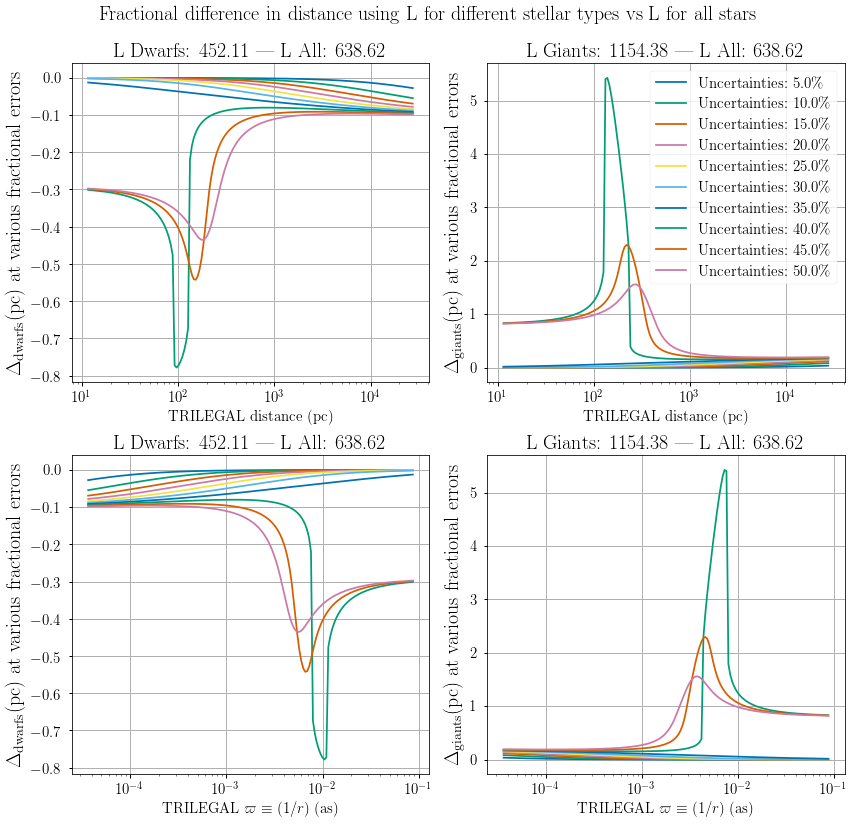

In [49]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
for err in errange:
    ax[0,0].semilogx(idf['r_true'],idf['d_dwarfs_'+str(np.round(err,2))])
    ax[0,1].semilogx(idf['r_true'],idf['d_giants_'+str(np.round(err,2))],label='Uncertainties: '+str(np.round(err,2)*100)+'\%')
    ax[1,0].semilogx(idf['oo'],idf['d_dwarfs_'+str(np.round(err,2))])
    ax[1,1].semilogx(idf['oo'],idf['d_giants_'+str(np.round(err,2))])

ax[0,0].set_xlabel('TRILEGAL distance (pc)',fontsize=15)
ax[0,0].set_ylabel(r'$\Delta_{\rm dwarfs}$(pc) at various fractional errors',fontsize=20)
ax[0,0].set_title('L Dwarfs: '+str(np.round(L_dwarf,2)) + ' | L All: '+str(np.round(L_all,2)), fontsize=20)
ax[0,0].grid()

ax[0,1].set_xlabel('TRILEGAL distance (pc)',fontsize=15)
ax[0,1].set_ylabel(r'$\Delta_{\rm giants}$(pc) at various fractional errors',fontsize=20)
ax[0,1].set_title('L Giants: '+str(np.round(L_giant,2)) + ' | L All: '+str(np.round(L_all,2)), fontsize=20)
ax[0,1].grid()
ax[0,1].legend(fancybox=True,loc='best',fontsize=15)

ax[1,0].axvline((1/2*L_all),linestyle='--',alpha=.5)    
ax[1,0].set_xlabel(r'TRILEGAL $\varpi \equiv (1/r)$ (as)',fontsize=15)
ax[1,0].set_ylabel(r'$\Delta_{\rm dwarfs}$(pc) at various fractional errors',fontsize=20)
ax[1,0].set_title('L Dwarfs: '+str(np.round(L_dwarf,2)) + ' | L All: '+str(np.round(L_all,2)), fontsize=20)
ax[1,0].grid()

ax[1,1].axvline((1/2*L_all),linestyle='--',alpha=.5)    
ax[1,1].set_xlabel(r'TRILEGAL $\varpi \equiv (1/r)$ (as)',fontsize=15)
ax[1,1].set_ylabel(r'$\Delta_{\rm giants}$(pc) at various fractional errors',fontsize=20)
ax[1,1].set_title('L Giants: '+str(np.round(L_giant,2)) + ' | L All: '+str(np.round(L_all,2)), fontsize=20)
ax[1,1].grid()                  

fig.suptitle(r'Fractional difference in distance using L for different stellar types vs L for all stars',fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

There are a number of important observations we can make about these plots:

- The effect of the distance prior is *much* more significant for Giants with large parallax uncertainties. Given the large difference in the length scale used, this is expected, as in the prior dominated regime the fractional difference between the two esimates will be large.


- For all stars with parallax uncertainties below $\sim35\%$ the difference in the resulting distance is relatively low, underestimated by $<10\%$ for dwarf stars and overestimated by $<15\%$ for giants. This lies relatively close to the formal uncertainties quoted by BJ+18 in their catalogue.

I've plotted the same plots below but without uncertainties above $35\%$ for clarity before moving on to conclusions.

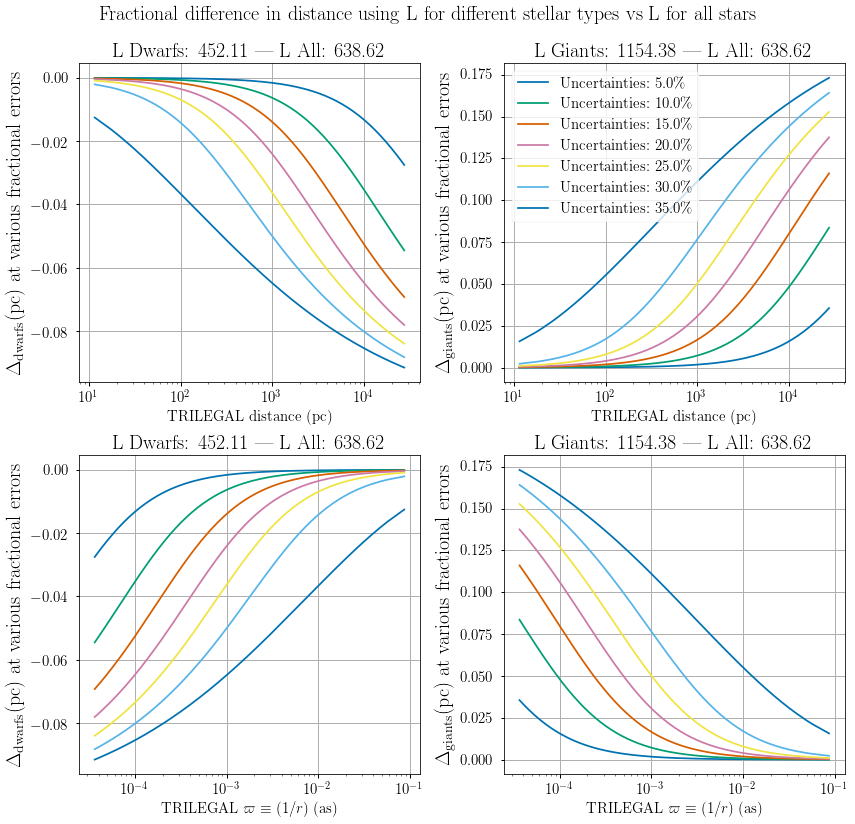

In [42]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
for err in errange[0:-3]:
    ax[0,0].semilogx(idf['r_true'],idf['d_dwarfs_'+str(np.round(err,2))])
    ax[0,1].semilogx(idf['r_true'],idf['d_giants_'+str(np.round(err,2))],label='Uncertainties: '+str(np.round(err,2)*100)+'\%')
    ax[1,0].semilogx(idf['oo'],idf['d_dwarfs_'+str(np.round(err,2))])
    ax[1,1].semilogx(idf['oo'],idf['d_giants_'+str(np.round(err,2))])

ax[0,0].set_xlabel('TRILEGAL distance (pc)',fontsize=15)
ax[0,0].set_ylabel(r'$\Delta_{\rm dwarfs}$(pc) at various fractional errors',fontsize=20)
ax[0,0].set_title('L Dwarfs: '+str(np.round(L_dwarf,2)) + ' | L All: '+str(np.round(L_all,2)), fontsize=20)
ax[0,0].grid()

ax[0,1].set_xlabel('TRILEGAL distance (pc)',fontsize=15)
ax[0,1].set_ylabel(r'$\Delta_{\rm giants}$(pc) at various fractional errors',fontsize=20)
ax[0,1].set_title('L Giants: '+str(np.round(L_giant,2)) + ' | L All: '+str(np.round(L_all,2)), fontsize=20)
ax[0,1].grid()
ax[0,1].legend(fancybox=True,loc='best',fontsize=15)

ax[1,0].set_xlabel(r'TRILEGAL $\varpi \equiv (1/r)$ (as)',fontsize=15)
ax[1,0].set_ylabel(r'$\Delta_{\rm dwarfs}$(pc) at various fractional errors',fontsize=20)
ax[1,0].set_title('L Dwarfs: '+str(np.round(L_dwarf,2)) + ' | L All: '+str(np.round(L_all,2)), fontsize=20)
ax[1,0].grid()

ax[1,1].set_xlabel(r'TRILEGAL $\varpi \equiv (1/r)$ (as)',fontsize=15)
ax[1,1].set_ylabel(r'$\Delta_{\rm giants}$(pc) at various fractional errors',fontsize=20)
ax[1,1].set_title('L Giants: '+str(np.round(L_giant,2)) + ' | L All: '+str(np.round(L_all,2)), fontsize=20)
ax[1,1].grid()                  

fig.suptitle(r'Fractional difference in distance using L for different stellar types vs L for all stars',fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<a id="conclusions"></a>
# Conclusions:

Can we 'trust' the distance values put forward by Bailer-Jones+18? I don't know if I can properly answer this question after this blog, and in an ideal world this would require a thorough analysis using identical *Galaxia* models, and taking into account other stellar types that may have different luminosity functions, such as variable stars and white dwarves, all which have parallaxes and distances given in the BJ+18 catalogue.

For now however, I think I can distill the following recommendations from this work:
- If you're using the BJ+18 given estimate $\texttt{r est}$ as your distance, make sure to include the formal uncertainties, and possbily inflate them to account for the fact that the length scale used may not be the best choice for your type of star.


- If you're using distances in a Bayesian fitting process, include the Bailer-Jones distance prior and see if you can do so for stars of globally uniform stellar type to avoid discrepancy in L values (i.e. avoid fitting dwarves and giants using the same L).


- Be reluctant to trust any distance value obtained using this prior for parallaxes with fractional uncertainties $\sigma_\varpi/\varpi \gtrapprox .35$ .

# What now?
If you've seen this blog and you're working on similar analysis, please let me know. If you find any errors in the code, content, or analysis above, please let me know so I can rectify it.

You can find me on: [Twitter](www.twitter.com/asteronomer) | [Github](www.github.com/ojhall94) | ojhall94 -at- gmail -dot- com

Good luck with your science and thanks for reading!